<a href="https://colab.research.google.com/github/kingSSG/Handwritten-Answer-Script-Grading-System/blob/main/Handwritten_Answer_Script_Grading_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [ ]:
import keras
from keras.layers import StringLookup
from keras import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
keras.utils.set_random_seed(42)


In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [ ]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for i, file_line in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

#############################################################################################
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)


test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
print(test_img_paths )
print(test_labels)

['data/words/g01/g01-067/g01-067-03-02.png', 'data/words/m04/m04-093/m04-093-07-01.png', 'data/words/l04/l04-179/l04-179-05-00.png', 'data/words/b05/b05-038/b05-038-01-00.png', 'data/words/l04/l04-163/l04-163-04-08.png', 'data/words/l07/l07-135/l07-135-07-04.png', 'data/words/e04/e04-022/e04-022-06-05.png', 'data/words/e02/e02-014/e02-014-01-00.png', 'data/words/e04/e04-022/e04-022-02-03.png', 'data/words/e04/e04-038/e04-038-04-04.png', 'data/words/n04/n04-039/n04-039-05-07.png', 'data/words/b06/b06-100/b06-100-07-03.png', 'data/words/f04/f04-016/f04-016-00-06.png', 'data/words/p02/p02-081/p02-081-02-04.png', 'data/words/h04/h04-071/h04-071-05-02.png', 'data/words/f07/f07-084a/f07-084a-10-03.png', 'data/words/c01/c01-014/c01-014-04-05.png', 'data/words/l07/l07-138/l07-138-06-05.png', 'data/words/a06/a06-051/a06-051-04-05.png', 'data/words/g06/g06-050h/g06-050h-06-00.png', 'data/words/g06/g06-050m/g06-050m-08-04.png', 'data/words/d06/d06-063/d06-063-07-02.png', 'data/words/j06/j06-005/j

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
print(validation_labels_cleaned)
print(test_labels_cleaned)

['able', 'full', '.', 'act', 'you', 'National', '-', 'abyss', 'said', 'in', 'Aviation', '.', 'in', 'Ministry', 'the', 'otherwise', 'I', 'appears', 'of', 'be', 'expose', 'Defence', 'our', 'gesture', 'you', ',', 'Nor', '.', 'to', 'say', '"', 'about', 'us', 'economic', 'the', 'had', 'only', 'and', 'few', 'robbery', 'By', 'Week', 'circumstances', 'holds', 'Soil', '"', 'occur', '.', 'Jeannie', 'end', 'written', 'photographs', 'on', 'great', '?', 'to', 'public', 'of', '1960s', 'and', 'And', 'regarded', 'told', ',', 'finger', 'an', 'His', 'spend', 'One', 'heart', ',', 'opportunities', 'way', ',', 'to', 'only', 'saying', 'conventional', 'bases', 'on', '.', 'This', 'been', 'I', 'verse', 'deterioration', 'even', 'was', 'who', 'week', 'thing', '.', 'and', 'way', 'cluster', 'evening', '.', 'assumption', 'teach', 'Peacock', 'was', 'on', 'to', '.', 'predatory', 'of', 'the', 'was', 'of', 'their', '.', 'Britain', 'his', '?', 'Diefen-', '1/4', 'in', ';', 'to', 'Americans', 'must', 'correspond', 'way', 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - ops.shape(image)[0]
    pad_width = w - ops.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = ops.transpose(image, (1, 0, 2))
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomTranslation

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.05),
    RandomZoom(0.1, 0.1),
    RandomTranslation(0.1, 0.1)
])


def preprocess_image_with_distortion(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = ops.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)   # <-- just added this line

    return image


def vectorize_label_with_distortion(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = ops.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels_with_distortion(image_path, label):
    image = preprocess_image_with_distortion(image_path)
    label = vectorize_label_with_distortion(label)
    return {"image": image, "label": label}


def prepare_dataset_with_distortion (image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels_with_distortion, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [ ]:
train_ds = prepare_dataset_with_distortion(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset_with_distortion(validation_img_paths, validation_labels_cleaned)
#test data---------------------------------------------------------
test_ds = prepare_dataset_with_distortion(test_img_paths, test_labels_cleaned)

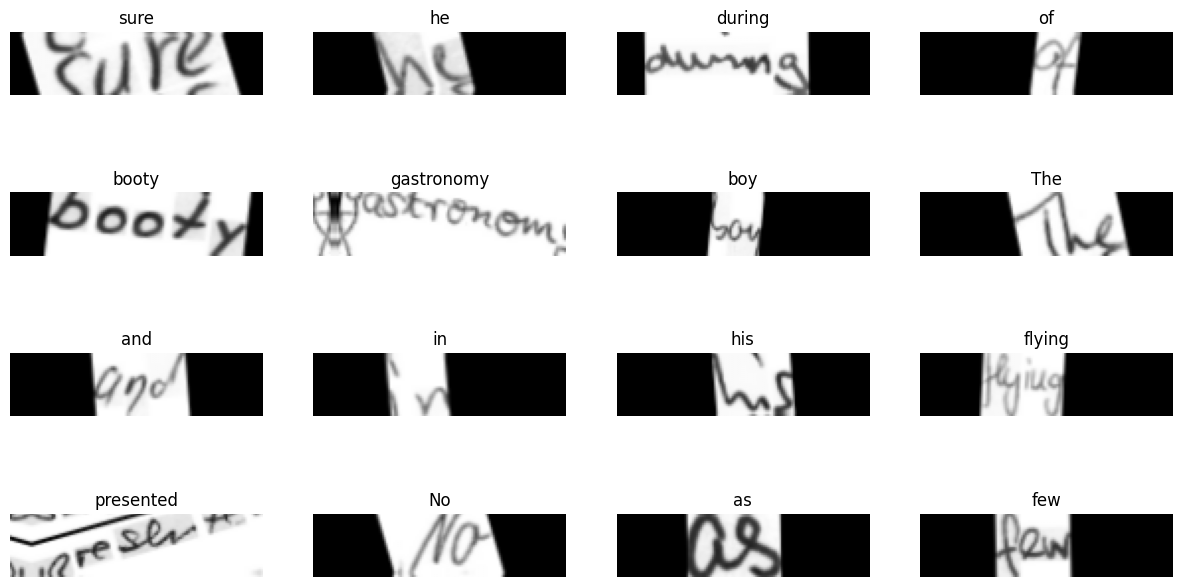

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # # RNNs.
    # x = keras.layers.Bidirectional(
    #     keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    # )(x)
    # x = keras.layers.Bidirectional(
    #     keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    # )(x)

    #new add rnns
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.4))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.4))(x)


    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()



Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 16,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 64, 16,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 81)    │     10,449 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 81)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

**# calculate_edit_distance**


In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = ops.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.ops.nn.ctc_decode(
        predictions, sequence_lengths=input_len
    )[0][0][:, :max_len]
    sparse_predictions = ops.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [ ]:
epochs = 50  # To get good results this should be at least 50.

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Metric to watch
    patience=5,                # Wait for 5 epochs before stopping
    restore_best_weights=True # Restore best model, not last one
)




model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, early_stopping],
)


Epoch 1/50
  88/1357 ━━━━━━━━━━━━━━━━━━━━ 16:32 782ms/step - loss: 2510.7708

KeyboardInterrupt: 

In [ ]:
# Load the trained model with the custom CTCLayer
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)
    return output_text

NameError: name 'prediction_model' is not defined

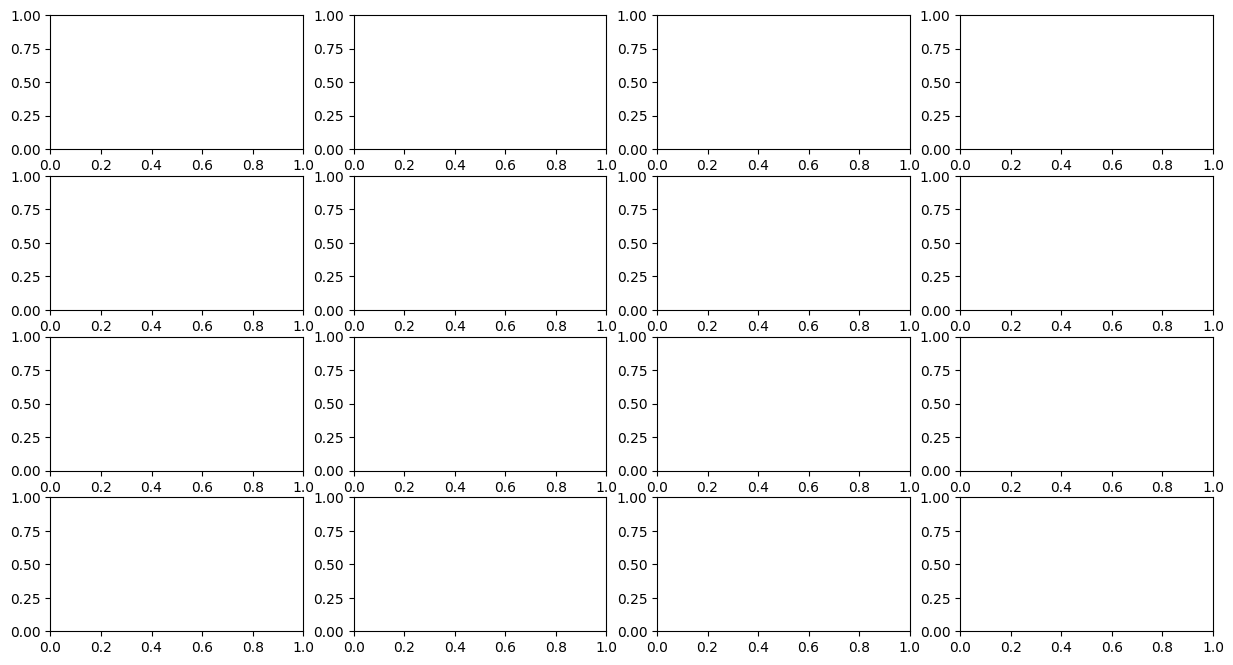

In [ ]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot Epoch vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()


prediction_model.save("handwriting_recognition_model.h5")


In [ ]:
# prediction_model.save("handwriting_recognition_model.h5")


In [ ]:

# # Provide the path to your custom image
# image_path ='/content/a01-000u-00-01.png'
# img_size=(128,32)
# imagetest = tf.io.read_file(image_path)
# imagetest = tf.image.decode_png(imagetest, 1)
# imagetest = distortion_free_resize(imagetest, img_size)
# imagetest = ops.cast(imagetest, tf.float32) / 255.0

# # Reshape imagetest to have an extra dimension for the batch size
# imagetest = tf.expand_dims(imagetest, axis=0) # Add batch dimension

# preds = prediction_model.predict(imagetest)

# # Output the prediction
# # pred_texts likely contains the previous predictions from the test set
# # To get the prediction for imagetest, decode the current predictions:
# pred_texts = decode_batch_predictions(preds) # Decode predictions
# print("Predicted Text:", pred_texts) # Access the prediction

# loding model and testing


**working with loaded model**


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files
uploaded = files.upload()
image_name = "/content/"+list(uploaded.keys())[0]
print(image_name)


Saving WhatsApp Image 2025-05-21 at 23.32.43_362f53fa.jpg to WhatsApp Image 2025-05-21 at 23.32.43_362f53fa.jpg
/content/WhatsApp Image 2025-05-21 at 23.32.43_362f53fa.jpg


In [ ]:
# Load the saved model
loaded_model = load_model("/content/handwriting_recognition_model.h5", compile=False)

In [ ]:
# image_path =image_name#'/content/hello.jpg'
# img_size=(128,32)
# imagetest = tf.io.read_file(image_path)
# imagetest = tf.image.decode_png(imagetest, 1)
# imagetest = distortion_free_resize(imagetest, img_size)
# imagetest = ops.cast(imagetest, tf.float32) / 255.0

# # Reshape imagetest to have an extra dimension for the batch size
# imagetest = tf.expand_dims(imagetest, axis=0) # Add batch dimension

# preds = loaded_model.predict(imagetest)

# # Output the prediction
# # pred_texts likely contains the previous predictions from the test set
# # To get the prediction for imagetest, decode the current predictions:
# pred_texts = decode_batch_predictions(preds) # Decode predictions
# print("Predicted Text:", pred_texts) # Access the prediction


### **Line and word segmentation**


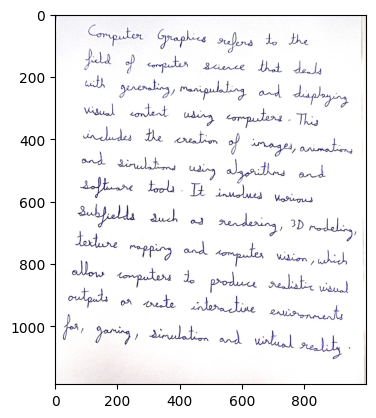

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:

    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);

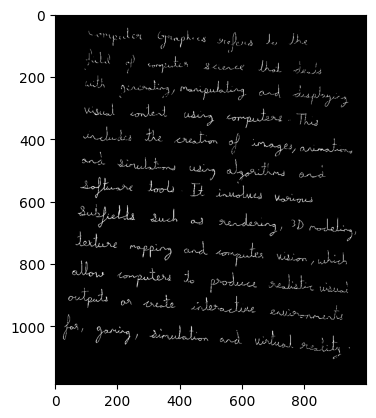

In [ ]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

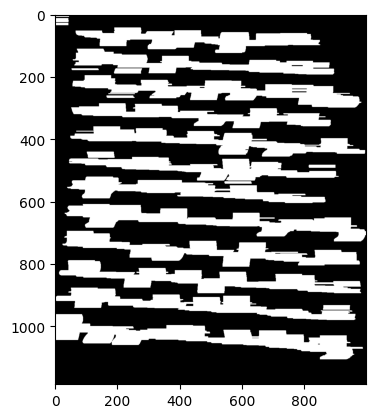

In [ ]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [ ]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

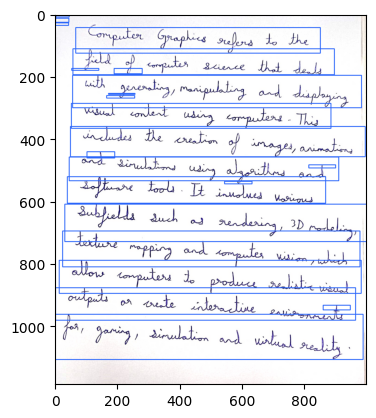

In [ ]:
img2 = img.copy()

for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)

plt.imshow(img2);

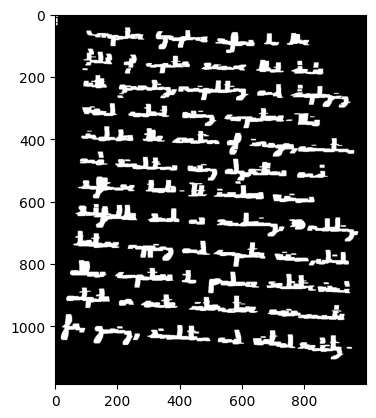

In [ ]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

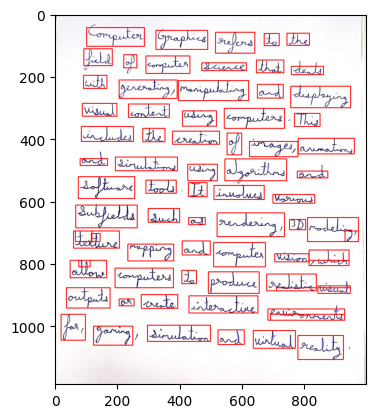

In [ ]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:

    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+h, x:x+w]

    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])

    for word in sorted_contour_words:

        if cv2.contourArea(word) < 400:
            continue

        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,000,000),2)

plt.imshow(img3);

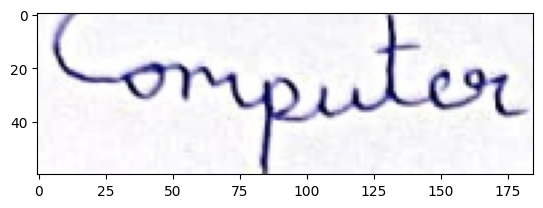

In [ ]:
ninth_word = words_list[0]
roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

In [ ]:
# prepare_dataset(test_img_paths, test_labels_cleaned)

In [ ]:
# import matplotlib.pyplot as plt

# for i in range(len(words_list)):
#     ninth_word = words_list[i]
#     roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]

#     plt.imshow(roi_9, cmap='gray')  # Display the word image
#     plt.title(f'Word {i+1}')  # Add title for reference
#     plt.axis('off')  # Remove axes for clarity
#     plt.show()  # Show the image before moving to the next one


working prediction


In [ ]:

import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
# Load the trained model (make sure CTCLayer is defined if needed)
img_size = (128, 32)  # Model input size
predicted_texts = []

for i, word in enumerate(words_list):
    # Extract the ROI for the word.
    # Assuming words_list entries contain coordinates in the order: [x_min, y_min, x_max, y_max]
    roi = img[word[1]:word[3], word[0]:word[2]]

    # Instead of saving to disk, encode the ROI to a PNG in memory.
    success, encoded_image = cv2.imencode('.png', roi)
    if not success:
        print(f"Could not encode ROI for word index {i}")
        continue

    # Convert the encoded buffer to bytes.
    image_bytes = encoded_image.tobytes()

    # Decode the PNG bytes to a TensorFlow image.
    imagetest = tf.io.decode_png(image_bytes, channels=1)

    # Resize the image using your distortion_free_resize function.
    imagetest = distortion_free_resize(imagetest, img_size)

    # Normalize the image.
    imagetest = tf.cast(imagetest, tf.float32) / 255.0

    # Expand dimensions to create a batch of size 1.
    imagetest = tf.expand_dims(imagetest, axis=0)  # (1, height, width, channels)

    # Run prediction.
    preds = loaded_model.predict(imagetest)
    pred_text = decode_batch_predictions(preds)[0]
    predicted_texts.append(pred_text)

    print(f"Word {i + 1}: {pred_text}")

# Optionally, join all words to form a sentence.
final_sentence = " ".join(predicted_texts)
print("\nFinal Predicted Sentence:")
print(final_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
Word 1: Lomputor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Word 2: bpraplies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Word 3: sefons
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Word 4: to
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Word 5: the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Word 6: fild
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Word 7: o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Word 8: computes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Word 9: siece
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Word 10: that
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Word 11: deas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Word 12: with
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Word 13: gerenatingg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Word 14: mriputating
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Word 15: and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Word 16: dnplaying
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Word 17: Misual
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Word 18: wrtent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
W

### **sequence to sequence model**


In [ ]:
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.saving import register_keras_serializable

# --- Custom layer fix ---
@register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, depth, **kwargs):
        super().__init__(**kwargs)
        self.length = length
        self.depth = depth
        self.pos_encoding = self.positional_encoding(length, depth)[tf.newaxis]

    def positional_encoding(self, length, depth):
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(depth)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(depth))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({"length": self.length, "depth": self.depth})
        return config

# --- Load model and metadata ---
model = keras.models.load_model(
    "ocr_correction_model.keras",
    custom_objects={"PositionalEncoding": PositionalEncoding}
)

with open("char2idx.json") as f:
    char2idx = json.load(f)

with open("idx2char.json") as f:
    idx2char = json.load(f)
    idx2char = {int(k): v for k, v in idx2char.items()}

with open("model_metadata.json") as f:
    metadata = json.load(f)

max_len = metadata["max_len"]

# --- Encode/Decode ---
def encode(text):
    ids = [char2idx.get(c, char2idx.get("<unk>", 0)) for c in text]
    ids = ids[:max_len] + [char2idx["<pad>"]] * (max_len - len(ids))
    return ids

def decode_prediction(prediction):
    pred_ids = np.argmax(prediction[0], axis=-1)
    chars = [idx2char.get(i, '') for i in pred_ids if i > 1]
    return ''.join(chars).strip()

# --- Greedy decoding (can be extended with beam) ---
def correct_ocr(text):
    enc_input = np.array([encode(text)])
    dec_input = np.zeros((1, max_len), dtype=int)
    dec_input[0, 0] = char2idx["<sos>"]

    for i in range(1, max_len):
        preds = model.predict([enc_input, dec_input], verbose=0)
        next_token = np.argmax(preds[0, i - 1])
        if next_token == char2idx["<pad>"]:
            break
        dec_input[0, i] = next_token

    return decode_prediction(preds)

# --- Chunking with overlap and deduplication ---
def split_chunks(text, chunk_size=128, overlap=32):
    step = chunk_size - overlap
    chunks = []
    for i in range(0, len(text), step):
        chunk = text[i:i + chunk_size]
        chunks.append(chunk)
        if i + chunk_size >= len(text):
            break
    return chunks

def deduplicate_chunks(chunks, overlap=32):
    deduped = chunks[0]
    for i in range(1, len(chunks)):
        overlap_chunk = chunks[i][:overlap]
        for j in range(overlap, 0, -1):
            if deduped[-j:] == overlap_chunk[:j]:
                deduped += chunks[i][j:]
                break
        else:
            deduped += chunks[i]
    return deduped

def correct_long_text(text):
    chunks = split_chunks(text, chunk_size=max_len, overlap=32)
    corrected_chunks = [correct_ocr(chunk) for chunk in chunks]
    return deduplicate_chunks(corrected_chunks, overlap=32)

# --- Example ---
input_text = final_sentence

print("Input:", input_text)
output_text_s2s = correct_long_text(input_text)
print("Output:",output_text_s2s )


# **levenshtein**

In [ ]:
import nltk
nltk.download("words")
from nltk.corpus import words

dictionary_words = set(w.lower() for w in words.words())

import difflib

# Example of prioritized expected words (manually curated)
expected_words = {"intelligence", "simulation", "vision", "language", "neural", "computing"}

def correct_word(word, expected_words, dictionary_words, threshold=0.8):
    # Try expected words first (more likely to match domain-specific terms)
    best = difflib.get_close_matches(word, expected_words, n=1, cutoff=threshold)
    if best:
        return best[0]
    # Fall back to general dictionary
    best = difflib.get_close_matches(word, dictionary_words, n=1, cutoff=threshold)
    if best:
        return best[0]
    return word  # No match found

def refine_prediction(predicted_sentence, expected_words, dictionary_words):
    words = predicted_sentence.split()
    corrected = [correct_word(w.lower(), expected_words, dictionary_words) for w in words]
    return " ".join(corrected)

#usage
raw_output = output_text_s2s
refined_output = refine_prediction(raw_output, expected_words, dictionary_words)
print(refined_output)  # -> intelligence is good for simulation and vision

In [ ]:

# Install dependencies (if needed)
!pip install transformers scikit-learn torch numpy

In [ ]:
from transformers import BertTokenizer, BertModel, pipeline
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

# Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name).to(device)
model.eval()

# Load sentiment analysis model fine-tuned on SST-2
sentiment_analyzer = pipeline("sentiment-analysis", model="textattack/bert-base-uncased-SST-2")

def get_bert_embedding(text: str, method: str = 'cls') -> np.ndarray:
    """Generates a sentence embedding from BERT using the specified method ('cls' or 'mean')."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    if method == 'cls':
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()
    elif method == 'mean':
        token_embeddings = outputs.last_hidden_state[:, 1:-1, :] if inputs['input_ids'].shape[1] > 2 else outputs.last_hidden_state
        return torch.mean(token_embeddings, dim=1).cpu().numpy()
    else:
        raise ValueError("Invalid embedding method. Choose 'cls' or 'mean'.")

def grade_similarity_bert(doc1: str, doc2: str, embedding_method: str = 'cls') -> float:
    """Calculates cosine similarity between two texts using BERT embeddings."""
    embedding1 = get_bert_embedding(doc1, method=embedding_method)
    embedding2 = get_bert_embedding(doc2, method=embedding_method)
    return cosine_similarity(embedding1, embedding2)[0][0]

def get_sentiment_label(text: str) -> str:
    """Returns the sentiment label ('LABEL_1' = Positive, 'LABEL_0' = Negative)."""
    return sentiment_analyzer(text)[0]['label']

def penalized_similarity(doc1: str, doc2: str, embedding_method: str = 'cls', penalty_factor: float = 0.5, mean_threshold: float = 0.75) -> float:
    """Returns BERT similarity penalized if sentiment differs OR mean similarity is too low."""
    sim = grade_similarity_bert(doc1, doc2, embedding_method=embedding_method)

    sentiment1 = get_sentiment_label(doc1)
    sentiment2 = get_sentiment_label(doc2)

    mean_sim = grade_similarity_bert(doc1, doc2, embedding_method='mean')

    # Penalty if sentiment differs

    if mean_sim < 0.4:
      return 0.0

    if sentiment1 != sentiment2 and mean_sim < mean_threshold:
      sim *= penalty_factor ** 2
    elif sentiment1 != sentiment2 or mean_sim < mean_threshold:
      sim *= penalty_factor
    if mean_sim < 0.5:
      sim *= penalty_factor **3  # Extra whack

    return sim


def scale_to_10(similarity_score: float) -> float:
    """Scales cosine similarity (0 to 1) to a score out of 10, with negatives clamped to 0."""
    return max(0.0, similarity_score) * 10


# # ================== EXAMPLE USAGE ==================

# doc1 = "Computer Graphics refers to the field of computer science that deals with generating, manipulating, and displaying visual content using computers. This includes the creation of images, animations, and simulations using algorithms and software tools. It involves various subfields, such as rendering, 3D modeling, texture mapping, and computer vision, which allow computers to produce realistic visual outputs or create interactive environments for gaming, simulation, and virtual reality."
# doc2 = "Computer Graphics is a branch of computer science that focuses on creating and managing visual content with the help of computers. It involves generating pictures and moving images using different programs and tools. Areas like rendering, modeling in 3D, and applying textures are essential to making images that look real or developing virtual spaces for gaming and simulations. However, it is also closely tied to the process of analyzing visual data, even though this can sometimes overlap with computer vision."

# # Raw similarity (no penalty)
# sim_cls = grade_similarity_bert(doc1, doc2, embedding_method='cls')
# sim_mean = grade_similarity_bert(doc1, doc2, embedding_method='mean')

# # Penalized similarity (CLS only for this example)
# penalized_sim = penalized_similarity(doc1, doc2, embedding_method='cls')

# # Scaled scores
# scaled_cls = scale_to_10(sim_cls)
# scaled_mean = scale_to_10(sim_mean)
# scaled_penalized = scale_to_10(penalized_sim)

# # Output results
# print("BERT Similarity (CLS):", sim_cls)
# print("BERT Similarity (Mean):", sim_mean)
# print("BERT Similarity (CLS) — Penalized for sentiment mismatch:", penalized_sim)

# print("Scaled BERT Similarity (CLS out of 10):", scaled_cls)
# print("Scaled BERT Similarity (Mean out of 10):", scaled_mean)
# print("Scaled Penalized Similarity (CLS out of 10):", scaled_penalized)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine
import torch
import numpy as np

# Function for keyword extraction (using TF-IDF)
def extract_keywords(doc: str, top_n: int = 10) -> set:
    """Extract top_n keywords using TF-IDF."""
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([doc])

    # Get top n keywords based on TF-IDF scores
    scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    sorted_indices = np.argsort(scores)[::-1]

    keywords = [vectorizer.get_feature_names_out()[i] for i in sorted_indices[:top_n]]
    return set(keywords)

# Function for Jaccard similarity between two sets of keywords
def jaccard_similarity(set1: set, set2: set) -> float:
    """Computes Jaccard similarity between two sets of keywords."""
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) > 0 else 0.0

# Function to combine BERT and keyword similarity
def combined_similarity(doc1: str, doc2: str, embedding_method: str = 'cls', penalty_factor: float = 0.5, mean_threshold: float = 0.75, keyword_weight: float = 0.3) -> float:
    """Combines BERT similarity with keyword matching similarity."""

    # Get BERT similarity
    sim_cls = grade_similarity_bert(doc1, doc2, embedding_method=embedding_method)
    sim_mean = grade_similarity_bert(doc1, doc2, embedding_method='mean')

    penalized_sim = penalized_similarity(doc1, doc2, embedding_method=embedding_method, penalty_factor=penalty_factor, mean_threshold=mean_threshold)

    # Extract keywords from both documents
    keywords_doc1 = extract_keywords(doc1)
    keywords_doc2 = extract_keywords(doc2)

    # Calculate Jaccard similarity based on keywords
    keyword_sim = jaccard_similarity(keywords_doc1, keywords_doc2)

    # Combine the BERT similarity with keyword similarity
    combined_score = (1 - keyword_weight) * penalized_sim + keyword_weight * keyword_sim

    # Apply scaling to a score out of 10
    return scale_to_10(combined_score), sim_cls, keyword_sim


# ================== EXAMPLE USAGE ==================

# doc1 = "Computer Graphics refers to the field of computer science that deals with generating, manipulating, and displaying visual content using computers. This includes the creation of images, animations, and simulations using algorithms and software tools. It involves various subfields, such as rendering, 3D modeling, texture mapping, and computer vision, which allow computers to produce realistic visual outputs or create interactive environments for gaming, simulation, and virtual reality."
doc1=final_sentence
doc2 = "Computer Graphics is a branch of computer science that focuses on creating and managing visual content with the help of computers. It involves generating pictures and moving images using different programs and tools. Areas like rendering, modeling in 3D, and applying textures are essential to making images that look real or developing virtual spaces for gaming and simulations. However, it is also closely tied to the process of analyzing visual data, even though this can sometimes overlap with computer vision."

# Get combined similarity
final_score, sim_cls, keyword_sim = combined_similarity(doc1, doc2, embedding_method='cls', penalty_factor=0.5, mean_threshold=0.75, keyword_weight=0.3)

# Output results
print(f"BERT Similarity (CLS): {sim_cls}")
print(f"Keyword Similarity (Jaccard): {keyword_sim}")
print(f"Combined Similarity Score (out of 10): {final_score}")


ui part


!pip install gradio


In [ ]:
# import gradio as gr

# def predict_text(input_text):
#     # Call your model or function here
#     return "Output: " + input_text  # Replace with your actual logic

# iface = gr.Interface(fn=predict_text, inputs="text", outputs="text")
# iface.launch()
